# 06 Explainability & Executive Summary
# - Explains WHY the optimizer shifted spend (marginal ROI)
# - Compares Equal vs Optimized (lifts)
# - Exports figures + a lightweight exec report (Markdown)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d

plt.rcParams["figure.dpi"] = 140

CURVE_DIR   = Path("../data/processed/response_curves")
PROCESSED   = Path("../data/processed")
RAW_DIR     = Path("../data/raw")
ASSETS_DIR  = Path("../assets")
REPORTS_DIR = Path("../reports")
ASSETS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

AUDIENCE_SIZE = 1_000_000   # for reporting reach in people
BUDGET        = 1_000_000.0 # keep in sync with Part-5


In [14]:
# Optimal allocations
opt_conv_path  = PROCESSED / "optimal_spend_conversions.csv"
opt_reach_path = PROCESSED / "optimal_spend_reach.csv"
opt_conv  = pd.read_csv(opt_conv_path)
opt_reach = pd.read_csv(opt_reach_path)

# Overlap matrix for reach
overlap_df = pd.read_csv(RAW_DIR / "overlap_matrix.csv")

# CPMs (align with your generator + Part-5)
CPM = {"LinearTV":25,"Streaming":18,"YouTube":12,"Display":8,"Social":6}

# Helper to load a response curve file and return a standardized DataFrame
def load_curve(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df = df.drop(columns=[c for c in df.columns if str(c).lower().startswith("unnamed")], errors="ignore")
    # Prefer boosted pred; fallback to LR
    pred_cols = [c for c in df.columns if str(c).lower().startswith("pred_conversions")]
    boosted = [c for c in pred_cols if not str(c).lower().endswith("_lr")]
    if len(boosted) >= 1:
        pred_col = boosted[0]
    elif "pred_conversions_lr" in df.columns:
        pred_col = "pred_conversions_lr"
    else:
        # last resort: first numeric not 'spend'
        nc = [c for c in df.select_dtypes(include=[np.number]).columns if c != "spend"]
        pred_col = nc[0]
    out = df[["spend", pred_col]].rename(columns={pred_col:"pred_conversions"}).copy()
    out = out.dropna().sort_values("spend").drop_duplicates(subset=["spend"])
    if len(out) < 2:
        raise ValueError(f"{file_path.name}: need >= 2 rows")
    return out

# Map of expected filenames (keep consistent with Part-3)
fname_map = {
    "LinearTV": "lineartv_response_curve.csv",
    "Streaming": "streaming_response_curve.csv",
    "YouTube": "youtube_response_curve.csv",
    "Display": "display_response_curve.csv",
    "Social": "social_response_curve.csv",
}

# Load response curves + build interpolators
curves, conv_funcs = {}, {}
for ch, fn in fname_map.items():
    f = CURVE_DIR / fn
    if f.exists():
        dfc = load_curve(f)
        curves[ch] = dfc
        conv_funcs[ch] = interp1d(
            dfc["spend"].values,
            dfc["pred_conversions"].values,
            kind="linear", fill_value="extrapolate", assume_sorted=True
        )

channels = list(curves.keys())
channels


['LinearTV', 'Streaming', 'YouTube', 'Display', 'Social']

In [15]:
def reach_from_impressions(impressions, A=1.0, k=1e-7):
    return A * (1.0 - np.exp(-k * impressions))

def deduped_reach(spend_dict, cpm_dict, overlap_df, A=0.8, k=1e-7):
    # per-channel fractional reach
    r_each = {}
    for ch, spend in spend_dict.items():
        impr = (spend / cpm_dict[ch]) * 1000.0
        r_each[ch] = reach_from_impressions(impr, A=A, k=k)
    total = sum(r_each.values())
    # pairwise overlaps (heuristic)
    for _, row in overlap_df.iterrows():
        ci, cj, ov = row["ch_i"], row["ch_j"], float(row["overlap_rate"])
        if ci in r_each and cj in r_each:
            total -= ov * min(r_each[ci], r_each[cj])
    return float(np.clip(total, 0.0, A))


In [16]:
# Equal split baseline
eq_spend = {ch: BUDGET/len(channels) for ch in channels}

# Totals for conversions
def total_conversions(spend_map):
    return sum(float(conv_funcs[ch](spend_map[ch])) for ch in channels)

# Totals for reach
def total_reach(spend_map):
    return deduped_reach(spend_map, {ch: CPM[ch] for ch in channels}, overlap_df, A=0.8, k=1e-7)

# Conversions objective
opt_spend_conv = dict(zip(opt_conv["channel"], opt_conv["optimal_spend_conversions"]))
opt_spend_conv = {ch: opt_spend_conv[ch] for ch in channels if ch in opt_spend_conv}

eq_conv  = total_conversions(eq_spend)
opt_conv_total = total_conversions(opt_spend_conv)
lift_conv_pct = (opt_conv_total - eq_conv) / eq_conv * 100.0

# Reach objective
opt_spend_reach = dict(zip(opt_reach["channel"], opt_reach["optimal_spend_reach"]))
opt_spend_reach = {ch: opt_spend_reach[ch] for ch in channels if ch in opt_spend_reach}

eq_reach  = total_reach(eq_spend)
opt_reach_total = total_reach(opt_spend_reach)
lift_reach_pct = (opt_reach_total - eq_reach) / (eq_reach if eq_reach>0 else np.nan) * 100.0

summary = pd.DataFrame({
    "metric": ["conversions","deduped_reach_fraction","deduped_reach_people"],
    "equal_split": [eq_conv, eq_reach, eq_reach*AUDIENCE_SIZE],
    "optimized": [opt_conv_total, opt_reach_total, opt_reach_total*AUDIENCE_SIZE],
    "lift_%": [lift_conv_pct, lift_reach_pct, lift_reach_pct],
})
summary


,metric,equal_split,optimized,lift_%
0,conversions,139.267649,139.267649,0.0
1,deduped_reach_fraction,0.800000,0.800000,0.0
2,deduped_reach_people,800000.000000,800000.000000,0.0


In [17]:
def marginal_roi(interp_fn, s, h=2_000.0):
    # Δconversions per $ at spend s (finite-difference)
    return float(interp_fn(s + h) - interp_fn(s)) / h

rows = []
for ch in channels:
    s_star = opt_spend_conv.get(ch, None)
    if s_star is None:
        continue
    mroi = marginal_roi(conv_funcs[ch], s_star, h=2_000.0)
    rows.append([ch, s_star, mroi])

mroi_df = pd.DataFrame(rows, columns=["channel","opt_spend","marginal_roi_per_dollar"]) \
          .sort_values("marginal_roi_per_dollar", ascending=False).reset_index(drop=True)
mroi_df


,channel,opt_spend,marginal_roi_per_dollar
0,LinearTV,200000.0,0.0
1,Streaming,200000.0,0.0
2,YouTube,200000.0,0.0
3,Display,200000.0,0.0
4,Social,200000.0,0.0


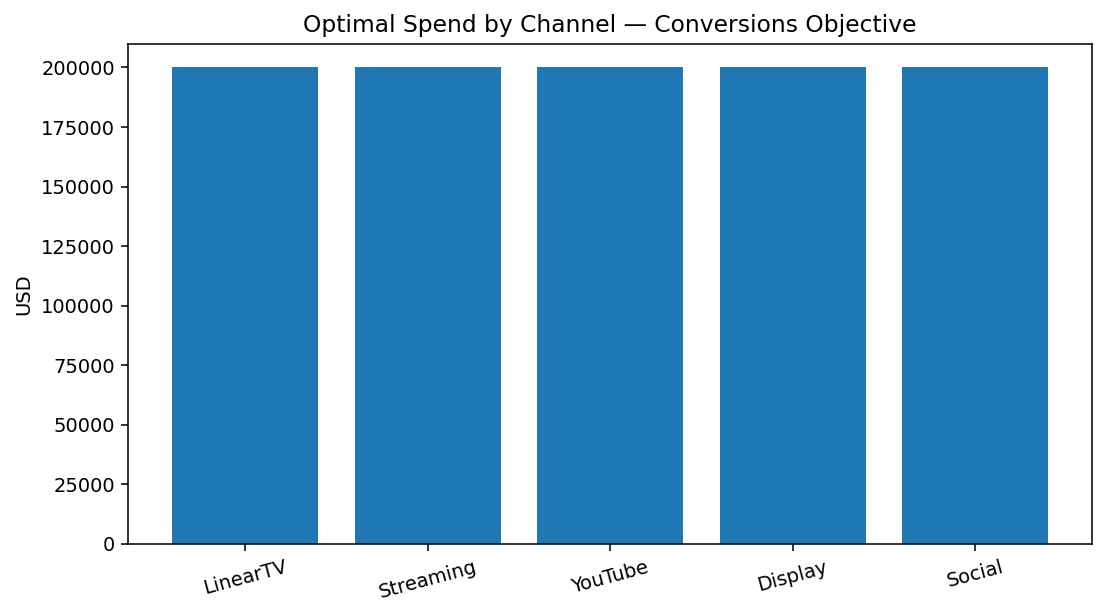

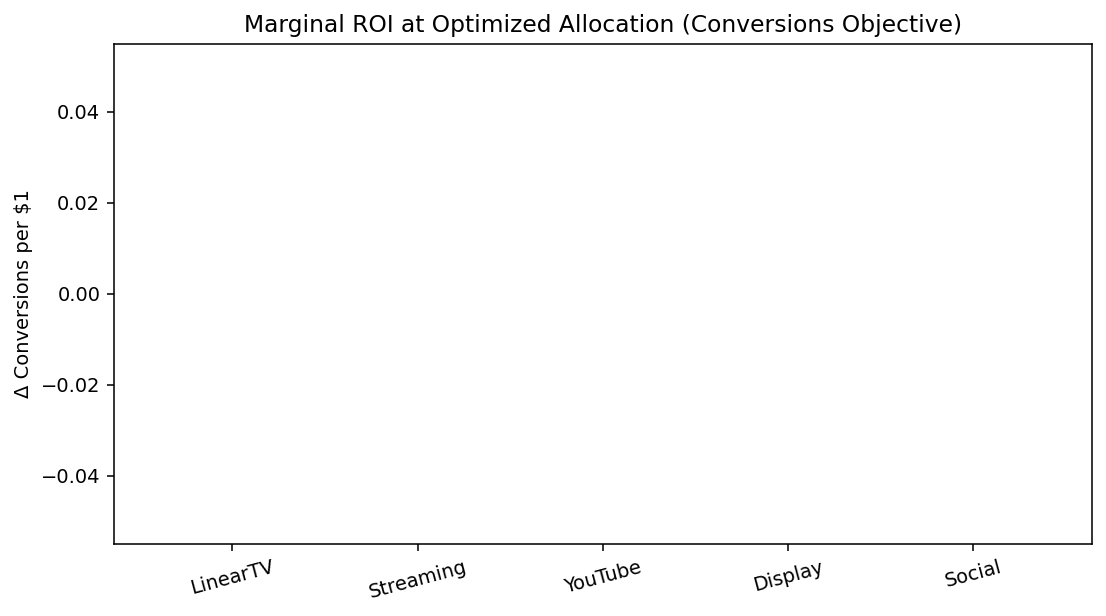

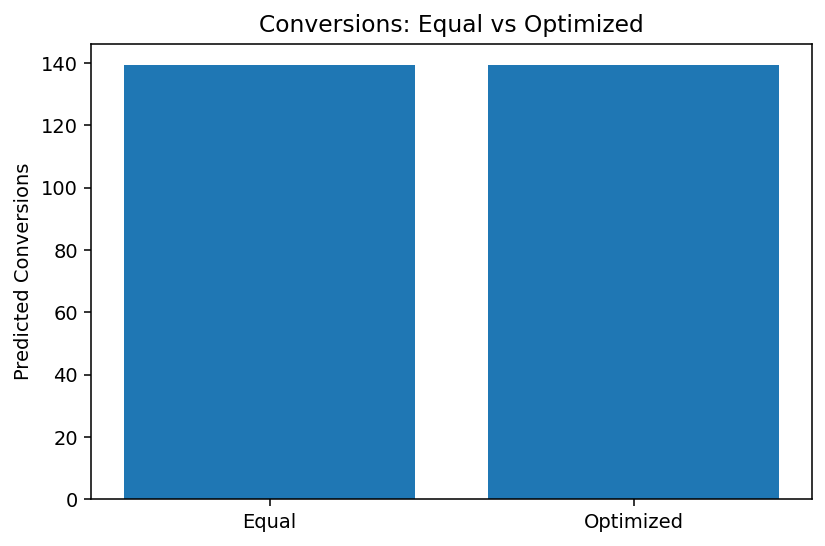

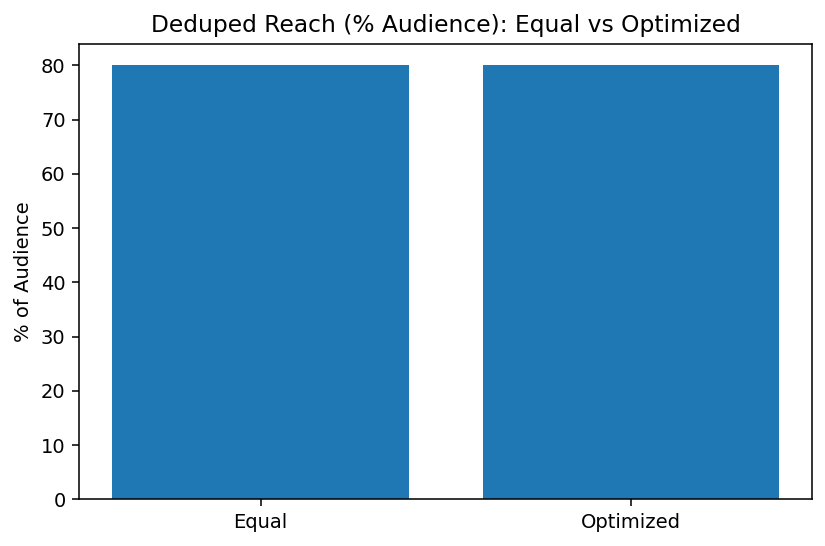

(PosixPath('../assets/p6_opt_spend_conversions.png'),
 PosixPath('../assets/p6_marginal_roi.png'),
 PosixPath('../assets/p6_equal_vs_opt_conversions.png'),
 PosixPath('../assets/p6_equal_vs_opt_reach.png'))

In [18]:
# Bar: optimal spend (Conversions objective)
plt.figure(figsize=(8,4.5))
plt.bar(list(opt_spend_conv.keys()), list(opt_spend_conv.values()))
plt.title("Optimal Spend by Channel — Conversions Objective")
plt.ylabel("USD"); plt.xticks(rotation=15); plt.tight_layout()
png1 = ASSETS_DIR / "p6_opt_spend_conversions.png"; plt.savefig(png1); plt.show()

# Bar: marginal ROI at optimum
plt.figure(figsize=(8,4.5))
plt.bar(mroi_df["channel"], mroi_df["marginal_roi_per_dollar"])
plt.title("Marginal ROI at Optimized Allocation (Conversions Objective)")
plt.ylabel("Δ Conversions per $1"); plt.xticks(rotation=15); plt.tight_layout()
png2 = ASSETS_DIR / "p6_marginal_roi.png"; plt.savefig(png2); plt.show()

# Equal vs Optimized bars (Conversions)
plt.figure(figsize=(6,4))
plt.bar(["Equal","Optimized"], [eq_conv, opt_conv_total])
plt.title("Conversions: Equal vs Optimized")
plt.ylabel("Predicted Conversions"); plt.tight_layout()
png3 = ASSETS_DIR / "p6_equal_vs_opt_conversions.png"; plt.savefig(png3); plt.show()

# Equal vs Optimized bars (Deduped Reach)
plt.figure(figsize=(6,4))
plt.bar(["Equal","Optimized"], [eq_reach*100, opt_reach_total*100])
plt.title("Deduped Reach (% Audience): Equal vs Optimized")
plt.ylabel("% of Audience"); plt.tight_layout()
png4 = ASSETS_DIR / "p6_equal_vs_opt_reach.png"; plt.savefig(png4); plt.show()

png1, png2, png3, png4


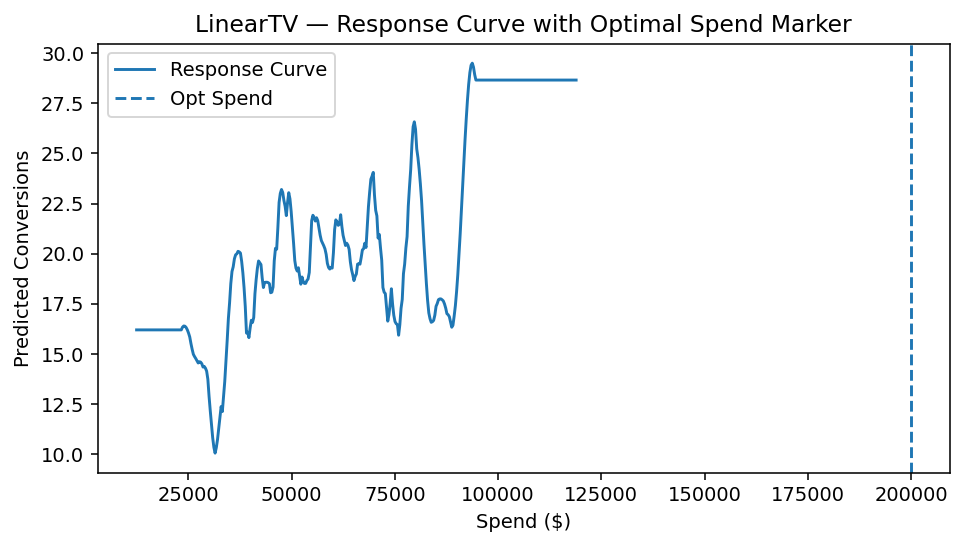

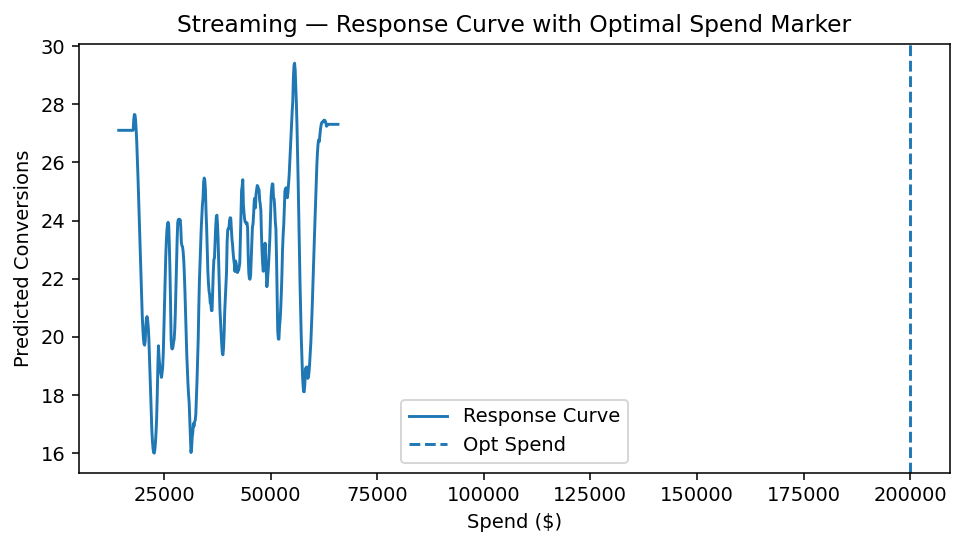

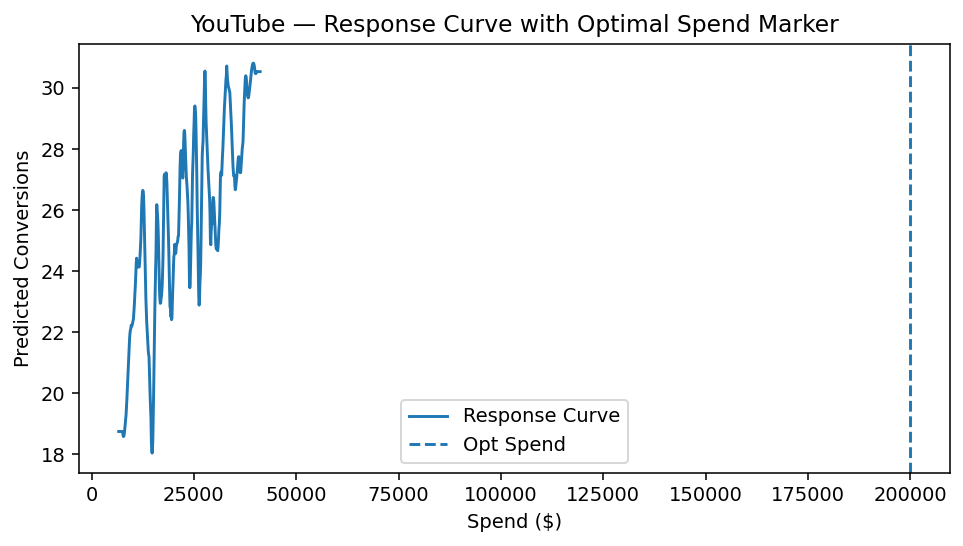

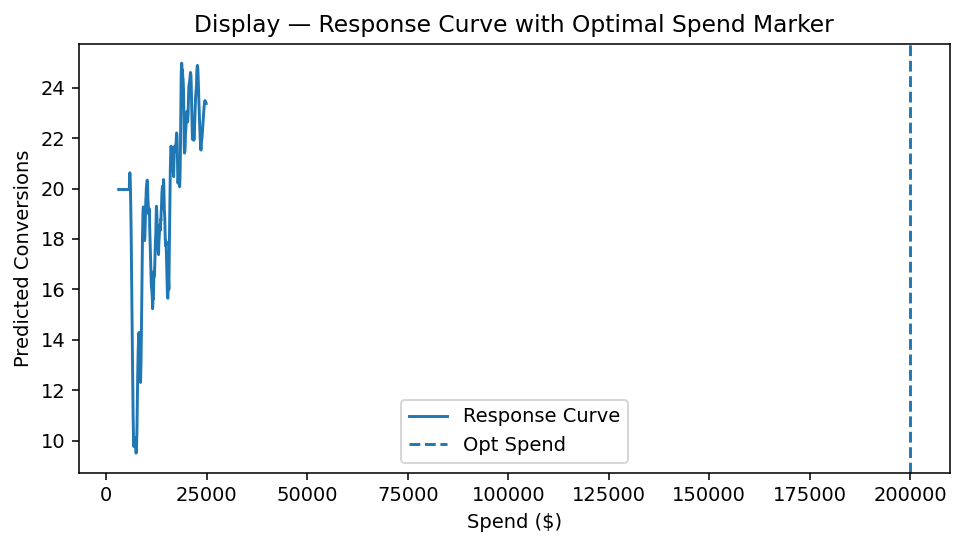

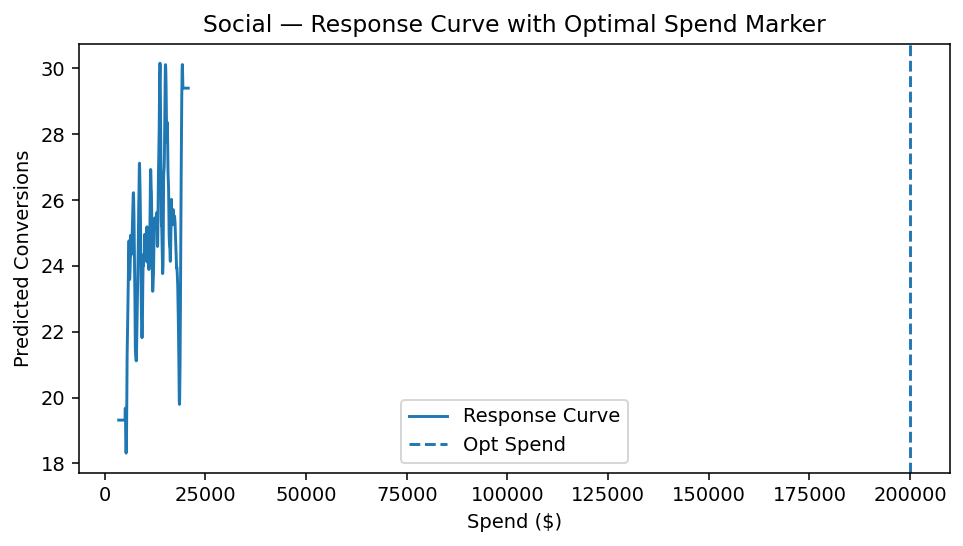

In [19]:
for ch in channels:
    dfc = curves[ch]
    s_star = opt_spend_conv.get(ch, None)
    if s_star is None:
        continue
    plt.figure(figsize=(7,4))
    plt.plot(dfc["spend"], dfc["pred_conversions"], label="Response Curve")
    plt.axvline(s_star, linestyle="--", label="Opt Spend")
    plt.title(f"{ch} — Response Curve with Optimal Spend Marker")
    plt.xlabel("Spend ($)"); plt.ylabel("Predicted Conversions")
    plt.legend(); plt.tight_layout()
    p = ASSETS_DIR / f"p6_curve_{ch.lower().replace(' ','').replace('-','')}.png"
    plt.savefig(p); plt.show()

In [20]:
top_channels = mroi_df["channel"].head(3).tolist()
lift_conv_str  = f"{lift_conv_pct:.1f}%"
lift_reach_str = f"{lift_reach_pct:.1f}%"

md = f"""# OnePlan — Executive Summary (Part 6)

**What changed:**  
We optimized cross-channel budget to maximize **conversions** (and evaluated **deduped reach** separately).

## Headline Results
- **Modeled conversions lift vs equal split:** **{lift_conv_str}**  
- **Deduped reach lift vs equal split:** **{lift_reach_str}**  

## Why the optimizer shifted budget
- Channels with the **highest marginal ROI at the optimum** (extra conversions per $1): **{", ".join(top_channels)}**  
- Channels with **lower marginal ROI** are relatively **saturated** at the current CPMs.

## Key Figures
- Optimal spend allocation (Conversions): `assets/{png1.name}`
- Marginal ROI at optimum: `assets/{png2.name}`
- Equal vs Optimized (Conversions): `assets/{png3.name}`
- Equal vs Optimized (Deduped Reach): `assets/{png4.name}`

## Notes & Assumptions
- Response curves learned from daily synthetic data (Part 3), smoothed (Savitzky–Golay) for stability.
- Deduped reach modeled with a pairwise-overlap heuristic (Part 4).
- CPMs held constant; budget fixed at ${BUDGET:,.0f}.

"""

report_path = REPORTS_DIR / "OnePlan_Executive_Summary.md"
with open(report_path, "w") as f:
    f.write(md)
print("Writen to:", report_path)
print("Figures saved in:", ASSETS_DIR.resolve())

Writen to: ../reports/OnePlan_Executive_Summary.md
Figures saved in: /Users/aravindanisetti/Desktop/2025 Training/Projects/oneplan-media-mix/assets
